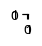

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [3]:
# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from src.train_eval import predict_bimodal, predict_model
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')


def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model = load_model_full(pt, js, return_json=False, verbose=False)
    return model
    

In [4]:
df = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')

In [5]:
df.query('

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type
0,SMWSFNPETNIL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHDN,FVKESK,ASSPLWDRGPLSYGYT,NaN,4,0,peptide_swapped,SPRWYFYYL,VDJdb_80565,35750048,SARS-CoV-2,beta
1,AVFDRKSDAK,TSDQSYG,QGSYDEQN,ALHSGGYQKVT,MNHEY,SMNVEV,ASSPTRPVEQY,HLA-A*11:01,4,0,peptide_swapped,GILGFVFTL,VDJdb_65943,28636592,InfluenzaA,paired
2,KLGGALQAK,TISGTDY,GLTSN,ILTETSYDKVI,SEHNR,FQNEAQ,ASASLGGGLYEQY,HLA-A*03:01,0,0,peptide_swapped,RAKFKQLL,ITRAP_793,37133356,NaN,paired
3,FVDGVPFVV,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHTA,FQGNSA,ASSFGTGWSDEQF,HLA-A*02:01,1,0,peptide_swapped,LPRRSGAAGA,IEDB_23086,28636589,Influenza A virus,beta
4,NLVPMVATV,YGATPY,YFSGDTLV,ALFNFGNDKLT,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,2,0,peptide_swapped,YVLDHLIVV,IEDB_150754,32184241,Human herpesvirus 4 (Epstein Barr virus),alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417088,GLCTLVAML,DRGSQS,IYSNGD,AVNHRDDKII,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,3,0,peptide_swapped,YLQPRTFLL,VDJdb_79199,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,alpha
417089,GLCTLVAML,DSSSTY,IFSNMDM,AESPGSGNTPLVI,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,0,1,IEDB,GLCTLVAML,IEDB_150417,32184241,Human herpesvirus 4 (Epstein Barr virus),alpha
417090,EIYKRWII,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SQVTM,ANQGSEA,SEQAPAGLRPSYNEQ,HLA-B*08:01,1,0,peptide_swapped,GILGFVFTL,IEDB_17378,28250417,Influenza A virus,beta
417091,QLMCQPILLL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHVS,FNYEAQ,ASSLAEGQESSYNSPLH,NaN,3,0,peptide_swapped,YEQYIKWPWYI,IEDB_81268,32793919,SARS-CoV2,beta
